<a href="https://colab.research.google.com/github/Vikranth3140/Agent-Berkley/blob/main/Sentiment-Analysis/sentiment-analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install torch
%pip install transformers
%pip install pandas matplotlib nltk
%pip install docling
%pip install pypdfium2
%pip install deepsearch-toolkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
pip install docling

In [1]:
from pathlib import Path
# from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    AcceleratorOptions,
    PdfPipelineOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption
# from docling.models.ocr_mac_model import OcrMacOptions
# from docling.models.tesseract_ocr_cli_model import TesseractCliOcrOptions
# from docling.models.tesseract_ocr_model import TesseractOcrOptions

In [4]:
# Example Code



In [6]:
'''

import nltk
from nltk.tokenize import sent_tokenize

# Download the necessary NLTK data
nltk.download('punkt_tab')

# Example text
text = "This is a sample sentence. This is another one."

# Try to tokenize
sentences = sent_tokenize(text)

# Print the sentences
for sentence in sentences:
    print(sentence)

'''

This is a sample sentence.
This is another one.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from typing import List, Dict, Optional
import textwrap
import re
import logging
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SentimentAnalyzerAgent:
    """An agent that performs sentiment analysis on financial texts using FinBERT."""

    def __init__(self, model_name: str = "yiyanghkust/finbert-tone", max_length: int = 512):
        """Initialize the agent with a model and tokenizer."""
        self.model_name = model_name
        self.max_length = max_length
        self.tokenizer, self.model = self._load_finbert()
        logger.info(f"Sentiment Analyzer Agent initialized with model: {model_name}")

    def _load_finbert(self) -> tuple:
        """Load the FinBERT model and tokenizer."""
        try:
            tokenizer = BertTokenizer.from_pretrained(self.model_name)
            model = BertForSequenceClassification.from_pretrained(self.model_name)
            return tokenizer, model
        except Exception as e:
            logger.error(f"Failed to load FinBERT: {e}")
            raise

    def _extract_text_from_pdf(self, pdf_path: str) -> str:
        """Extract text from PDF using Deep Search OCR pipeline."""
        try:
            # Configure pipeline options
            pipeline_options = PdfPipelineOptions()
            pipeline_options.do_ocr = True
            pipeline_options.do_table_structure = True
            pipeline_options.table_structure_options.do_cell_matching = True
            pipeline_options.ocr_options.lang = ["es"]
            pipeline_options.accelerator_options = AcceleratorOptions(
                num_threads=4, device=AcceleratorDevice.AUTO
            )

            doc_converter = DocumentConverter(
                format_options={
                    InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
                }
            )

            # Convert document
            conv_result = doc_converter.convert(pdf_path)

            # Define output directory
            output_dir = Path("scratch")
            output_dir.mkdir(parents=True, exist_ok=True)
            doc_filename = conv_result.input.file.stem

            # Export text version and read it
            text_output_path = output_dir / f"{doc_filename}.txt"
            with text_output_path.open("w", encoding="utf-8") as fp:
                fp.write(conv_result.document.export_to_text())

            # Read and return text content
            with text_output_path.open("r", encoding="utf-8") as fp:
                return fp.read().strip()

        except Exception as e:
            logger.error(f"Failed to process PDF with Deep Search pipeline: {e}")
            raise


    def _extract_text_from_pdf_like_content(self, pdf_text: str) -> str:
        """Extract and clean text from PDF-like OCR-tagged content."""
        content_blocks = re.findall(r'<CONTENT_FROM_OCR>(.*?)</CONTENT_FROM_OCR>', pdf_text, re.DOTALL)
        full_text = ""
        for block in content_blocks:
            if any(keyword in block.lower() for keyword in ["safe harbor", "e-voting", "instructions", "notice of the"]):
                continue
            cleaned_block = re.sub(r'(the red box\s+)+', ' ', block.strip())
            full_text += cleaned_block + "\n\n"
        return full_text.strip()

    def _preprocess_text(self, text: str) -> List[str]:
        """Split text into chunks using sentence-aware token-based logic."""
        sentences = sent_tokenize(text)
        chunks, current_chunk = [], []

        for sentence in sentences:
            tokens = self.tokenizer.encode(' '.join(current_chunk + [sentence]), add_special_tokens=False)
            if len(tokens) <= self.max_length:
                current_chunk.append(sentence)
            else:
                chunks.append(' '.join(current_chunk))
                current_chunk = [sentence]

        if current_chunk:
            chunks.append(' '.join(current_chunk))

        return chunks

    def _analyze_sentiment(self, chunks: List[str]) -> List[Dict]:
        """Run sentiment analysis on text chunks."""
        self.model.eval()
        sentiment_results = []
        label_map = {0: "negative", 1: "neutral", 2: "positive"}

        with torch.no_grad():
            for chunk in chunks:
                inputs = self.tokenizer(chunk, return_tensors="pt", truncation=True, padding=True, max_length=self.max_length)
                outputs = self.model(**inputs)
                logits = outputs.logits
                probs = torch.softmax(logits, dim=1).tolist()[0]

                pred_label_idx = torch.argmax(logits, dim=1).item()
                pred_label = label_map[pred_label_idx]
                confidence = probs[pred_label_idx]

                sentiment_results.append({
                    "text": chunk,
                    "sentiment": pred_label,
                    "confidence": confidence,
                    "probabilities": dict(zip(["negative", "neutral", "positive"], probs))
                })

        return sentiment_results

    def _aggregate_sentiment(self, sentiment_results: List[Dict]) -> Dict:
        """Aggregate sentiment across chunks."""
        avg_probs = {"negative": 0, "neutral": 0, "positive": 0}
        n_chunks = len(sentiment_results)

        for result in sentiment_results:
            for label, prob in result["probabilities"].items():
                avg_probs[label] += prob / n_chunks

        overall_sentiment = max(avg_probs, key=avg_probs.get)
        overall_confidence = avg_probs[overall_sentiment]

        return {
            "overall_sentiment": overall_sentiment,
            "overall_confidence": overall_confidence,
            "average_probabilities": avg_probs,
            "detailed_results": sentiment_results
        }

    def export_to_csv(self, results: List[Dict], filename: str = "sentiment_output.csv"):
        """Export chunk-level sentiment results to a CSV file."""
        rows = []
        for i, r in enumerate(results, 1):
            rows.append({
                "Chunk No.": i,
                "Sentiment": r["sentiment"],
                "Confidence": r["confidence"],
                "Negative": r["probabilities"]["negative"],
                "Neutral": r["probabilities"]["neutral"],
                "Positive": r["probabilities"]["positive"],
                "Text": r["text"]
            })
        df = pd.DataFrame(rows)
        df.to_csv(filename, index=False)
        logger.info(f"Results exported to {os.path.abspath(filename)}")

    def visualize_sentiments(self, results: List[Dict]):
        """Generate and display sentiment distribution pie and bar charts."""
        counts = {"positive": 0, "neutral": 0, "negative": 0}
        for r in results:
            counts[r["sentiment"]] += 1

        labels = list(counts.keys())
        values = list(counts.values())

        plt.figure(figsize=(6, 6))
        plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=140)
        plt.title("Sentiment Distribution (Pie Chart)")
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.bar(labels, values)
        plt.title("Sentiment Count per Label (Bar Chart)")
        plt.ylabel("Count")
        plt.xlabel("Sentiment")
        plt.show()

    def show_top_negative_chunks(self, results: List[Dict], top_n: int = 5):
        """Print top N chunks with highest negative sentiment."""
        sorted_res = sorted(results, key=lambda x: x["probabilities"]["negative"], reverse=True)[:top_n]
        print("\n=== Top Negative Chunks ===")
        for i, res in enumerate(sorted_res, 1):
            print(f"Chunk {i} - Neg Score: {res['probabilities']['negative']:.2f}")
            print(textwrap.shorten(res["text"], width=120, placeholder="..."))
            print()

    def run(self, input_data: str, source_type: str = "pdf") -> Dict:
        """
        Process input text and return sentiment analysis results.
        Args:
            input_data: Raw text (e.g., PDF content or OCR tagged).
            source_type: Type of input ('pdf', 'text', etc.).
        Returns:
            Dict with sentiment analysis results.
        """
        logger.info(f"Processing input data (source: {source_type})...")

        if source_type == "pdf":
            processed_text = self._extract_text_from_pdf_like_content(input_data)
        else:
            processed_text = input_data

        logger.info(f"Extracted text length: {len(processed_text)} characters")

        chunks = self._preprocess_text(processed_text)
        logger.info(f"Split into {len(chunks)} chunks")

        sentiment_results = self._analyze_sentiment(chunks)
        logger.info("Sentiment analysis completed")

        aggregated_result = self._aggregate_sentiment(sentiment_results)
        logger.info(f"Overall sentiment: {aggregated_result['overall_sentiment']} (Confidence: {aggregated_result['overall_confidence']:.2f})")

        return {
            "agent": "SentimentAnalyzer",
            "source_type": source_type,
            "result": aggregated_result
        }

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



=== Sentiment Analyzer Agent Output ===
{
  "agent": "SentimentAnalyzer",
  "source_type": "text",
  "result": {
    "overall_sentiment": "negative",
    "overall_confidence": 0.8863254394253618,
    "average_probabilities": {
      "negative": 0.8863254394253618,
      "neutral": 0.1033670620733411,
      "positive": 0.010307496564923198
    },
    "detailed_results": [
      {
        "text": "## Generative AI and You\n\nIntegrated Annual Report 2023-24\n\nThe cover and theme pages images have been created using gen AI tools. ## Gen AI: Ushering in the next era of business\n\nWe barely saw it happen. AI walking into our lives. Through the ads that follow us on social media. The personalized pick of movies and shows. Our cars. The maps helping us navigate. Right there in our hands - our super-powerful phones. And now, it's happening again. This time with generative AI. In the form of handy tools - like ChatGPT, MetaAI and Stable Diffusion - that pique our imagination, and stoke our c

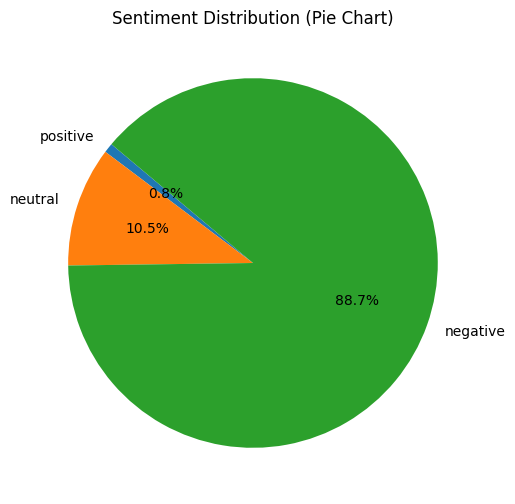

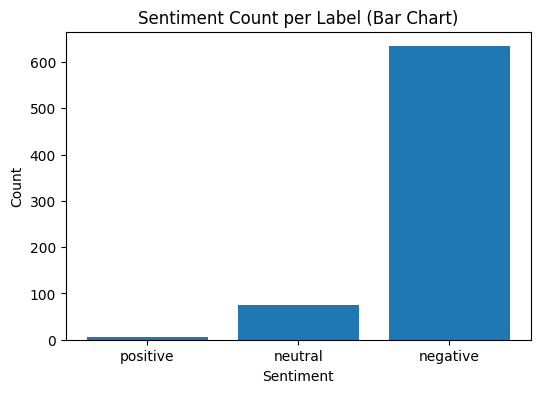


=== Top Negative Chunks ===
Chunk 1 - Neg Score: 1.00
Details of capital assets created or acquired through Corporate Social Responsibility amount spent during the...

Chunk 2 - Neg Score: 1.00
Number of days of accounts payable ((Accounts payable *365) / Cost of goods/services procured) in the following...

Chunk 3 - Neg Score: 1.00
Water withdrawal, consumption and discharge in areas of water stress (in kilolitres): | | For each facility / plant...

Chunk 4 - Neg Score: 1.00
The US dollar has been converted into the Indian rupee at the daily rates. The number of ADSs outstanding as on March...

Chunk 5 - Neg Score: 1.00
Job creation in smaller towns - Disclose wages paid to persons employed (including employees or workers employed on a...



In [8]:
if __name__ == "__main__":
    agent = SentimentAnalyzerAgent()

    # Use real PDF path here
    pdf_path = "annual-report-2024.pdf"
    pdf_text = agent._extract_text_from_pdf(pdf_path)

    result = agent.run(pdf_text, source_type="text")
    logger.info("Sentiment analysis completed.")

    print("\n=== Sentiment Analyzer Agent Output ===")
    print(json.dumps(result, indent=2, default=str))

    print(f"\nSummary:")
    print(f"Overall Sentiment: {result['result']['overall_sentiment'].capitalize()} (Confidence: {result['result']['overall_confidence']:.2f})")
    print("Average Probabilities:")
    for label, prob in result['result']['average_probabilities'].items():
        print(f"  {label.capitalize()}: {prob:.2f}")

    print("\nDetailed Results (First 3 Chunks):")
    for i, detail in enumerate(result['result']['detailed_results'][:3], 1):
        print(f"Chunk {i}:")
        print(f"  Text: {textwrap.shorten(detail['text'], width=50, placeholder='...')}")
        print(f"  Sentiment: {detail['sentiment'].capitalize()} (Confidence: {detail['confidence']:.2f})")

    agent.export_to_csv(result['result']['detailed_results'])
    agent.visualize_sentiments(result['result']['detailed_results'])
    agent.show_top_negative_chunks(result['result']['detailed_results'])